In [1]:
import numpy as np
import os
import wfdb
from collections import Counter
import pickle
import random
import sys
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import sklearn.metrics as skm
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
from sklearn.utils import resample

import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint
import seaborn as sns
import matplotlib.pyplot as plt


import itertools

2022-09-02 18:02:03.444508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-02 18:02:03.444706: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [3]:
def valt(mp):
    return (len(mp),mp[10],mp[11],mp[12])

def drop_nan(data):
    j = 0
    for x in data:
        if pd.isnull(x):
            data[j] = 0
        j = j + 1

def drop_zero(data):
    j = 0
    ms = data.mean()
    for x in data:
        if data[j] == 0.:
            data[j] = ms
        j = j + 1

In [4]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(128,(3), activation='relu', input_shape=im_shape)(inputs_cnn)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool1)
    pool2=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv2_1)

    conv3_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool2)
    pool3=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv3_1)

    conv4_1=Convolution1D(128, (3), activation='relu', input_shape=im_shape)(pool3)
    pool4=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv4_1)

    flatten=Flatten()(pool4)
    dense_end1 = Dense(128, activation='relu')(flatten)
    main_output = Dense(2, activation='sigmoid', name='main_output')(dense_end1)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    #callbacks = [EarlyStopping(monitor='val_loss', patience=10),
    #         ModelCheckpoint(filepath='md.bin', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=5, steps_per_epoch=100 ,validation_data=(X_test,y_test))
    #model.load_weights('md.h5')
    return(model,history)

In [5]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.savefig("ac_t2", dpi=300)
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.savefig("ac_t_22", dpi=300)
    plt.show()
    #target_names=['0','1','2','3','4']
    
    # Compute confusion matrix


In [6]:
rhy_dict = {'Sinus rhythm' : 1. ,
            'Sinus tachycardia' : 2. ,
            'Sinus bradycardia' : 3. ,
            'Sinus arrhythmia' : 4. ,
            'Irregular sinus rhythm' : 5. ,
            'Atrial fibrillation' : 6. ,
            'Atrial flutter, typical' : 7. ,
            'Abnormal rhythm' : 8. }

elec_dict = {'Electric axis of the heart: normal' : 1. ,
            'Electric axis of the heart: left axis deviation' : 2. ,
            'Electric axis of the heart: vertical' : 3. ,
            'Electric axis of the heart: horizontal' : 4. ,
            'Electric axis of the heart: right axis deviation' : 5. ,
            0. : 0. }

con_dict = {'Sinoatrial blockade, undefined' : 1. ,
            'I degree av block' : 2. ,
            'Iii degree av-block' : 3. ,
            'Incomplete right bundle branch block' : 4. ,
            'Incomplete left bundle branch block' : 5. ,
            'Left anterior hemiblock' : 6. ,
            'Complete right bundle branch block' : 7. ,
            'Complete left bundle branch block' : 8. ,
            'Non-specific intravintricular conduction delay' : 9. ,
            0. : 0. }


ext_dict = {'Atrial extrasystole: undefined' : 1. ,
            'Atrial extrasystole: low atrial' : 2. ,
            'Atrial extrasystole: left atrial' : 3. ,
            'Atrial extrasystole, SA-nodal extrasystole' : 4. ,
            'Atrial extrasystole, type: single pac' : 5. ,
            'Atrial extrasystole, type: bigemini' : 6. ,
            'Atrial extrasystole, type: quadrigemini' : 7. ,
            'Atrial extrasystole, type: allorhythmic pattern' : 8. ,
            'Ventricular extrasystole, morphology: polymorphic' : 9. ,
            'Ventricular extrasystole, localisation: rvot, anterior wall' : 10. ,
            'Ventricular extrasystole, localisation: rvot, antero-septal part' : 11. ,
            'Ventricular extrasystole, localisation: IVS, middle part' : 12. ,
            'Ventricular extrasystole, localisation: LVOT, LVS' : 13. ,
            'Ventricular extrasystole, localisation: LV, undefined' : 14. ,
            'Ventricular extrasystole, type: single pvc' : 15. ,
            'Ventricular extrasystole, type: intercalary pvc' : 16. ,
            'Ventricular extrasystole, type: couplet' : 17. ,
            0. : 0. }


hyp_dict = {'Right atrial hypertrophy' : 1. ,
            'Left atrial hypertrophy' : 2. ,
            'Right atrial overload' : 3. ,
            'Left atrial overload' : 4. ,
            'Left ventricular hypertrophy' : 5. ,
            'Right ventricular hypertrophy' : 6. ,
            'Left ventricular overload' : 7. ,
            0. : 0. }


card_dict = {'Pacemaker presence, undefined' : 1. ,
            'P-synchrony' : 2. ,
            0. : 0. }



isch_dict = {'Stemi: anterior wall' : 1. ,
            'Stemi: lateral wall' : 2. ,
            'Stemi: septal' : 3. ,
            'Stemi: inferior wall' : 4. ,
            'Stemi: apical' : 5. ,
            'Ischemia: anterior wall' : 6. ,
            'Ischemia: lateral wall' : 7. ,
            'Ischemia: septal' : 8. ,
            'Ischemia: inferior wall' : 9. ,
            'Ischemia: posterior wall' : 10. ,
            'Ischemia: apical' : 11. ,
            'Scar formation: lateral wall' : 12. ,
            'Scar formation: septal' : 13. ,
            'Scar formation: inferior wall' : 14. ,
            'Scar formation: posterior wall' : 15. ,
            'Scar formation: apical' : 16. ,
            'Undefined ischemia/scar/supp.NSTEMI: anterior wall' : 17. ,
            'Undefined ischemia/scar/supp.nstemi: lateral wall' : 18. ,
            'Undefined ischemia/scar/supp.NSTEMI: septal' : 19. ,
            'Undefined ischemia/scar/supp.nstemi: inferior wall' : 20. ,
            'Undefined ischemia/scar/supp.nstemi: posterior wall' : 21. ,
            'Undefined ischemia/scar/supp.nstemi: apical' : 22. ,
            0. : 0. }



nons_dict = {'Non-specific repolarization abnormalities: inferior wall' : 1. ,
            'Non-specific repolarization abnormalities: lateral wall' : 2. ,
            'Non-specific repolarization abnormalities: anterior wall' : 3. ,
            'Non-specific repolarization abnormalities: posterior wall' : 4. ,
            'Non-specific repolarization abnormalities: apical' : 5. ,
            'Non-specific repolarization abnormalities: septal' : 6. ,
            0. : 0. }


oth_dict = {'Early repolarization syndrome' : 1. ,
            0. : 0. }

sex_dict = {'M' : 1. ,
            'F' : 0. }




In [7]:
path = 'ludb'
save_path = ''
# valid_lead = ['MLII', 'II', 'I', 'MLI', 'V5'] 
#valid_lead = ['MLII'] 
fs_out = 500
test_ratio = 0.2

In [8]:
with open(os.path.join(path, 'RECORDS'), 'r') as fin:
    all_record_name = fin.read().strip().split('\n')

In [9]:
#all_record_name

data_files = ["ludb/data/" + file for file in os.listdir("ludb/data/") if ".dat" in file]


data_files = sorted(data_files, key=valt)

#data_files

chanel = []
signal_out = []
signal_all = []

In [10]:
for miki in data_files:
    #signal_out = []
    for i in range(12):
        chanel = []
        chanel.append(i)
        sig = wfdb.rdsamp(miki[:-4], channels=chanel)
        sig_1d = np.ravel(sig[0])
        signal_all.append(sig_1d)

        #signal_out.extend(sig_1d)
            
        #signal_all.append(signal_out)

df = pd.DataFrame(signal_all)

print(df.shape)

(2400, 5000)


In [11]:
df_2 = pd.read_csv(path+'/ludb.csv')

In [12]:
df_2['Age'] = df_2['Age'].str.split('\n').str[0]
df_2['Sex'] = df_2['Sex'].str.split('\n').str[0]
df_2['Ischemia'] = df_2['Ischemia'].str.split('\n').str[0]
df_2['Cardiac pacing'] = df_2['Cardiac pacing'].str.split('\n').str[0]
df_2['Extrasystolies'] = df_2['Extrasystolies'].str.split('\n').str[0]
df_2['Non-specific repolarization abnormalities'] = df_2['Non-specific repolarization abnormalities'].str.split('\n').str[0]
df_2['Hypertrophies'] = df_2['Hypertrophies'].str.split('\n').str[0]
df_2['Electric axis of the heart'] = df_2['Electric axis of the heart'].str.split('\n').str[0]
df_2['Rhythms'] = df_2['Rhythms'].str.split('\n').str[0]
df_2['Conduction abnormalities'] = df_2['Conduction abnormalities'].str.split('\n').str[0]
df_2['Other states'] = df_2['Other states'].str.split('\n').str[0]



In [13]:
drop_nan(df_2['Conduction abnormalities'])
drop_nan(df_2['Extrasystolies'])
drop_nan(df_2['Hypertrophies'])
drop_nan(df_2['Cardiac pacing'])
drop_nan(df_2['Ischemia'])
drop_nan(df_2['Non-specific repolarization abnormalities'])
drop_nan(df_2['Other states'])
drop_nan(df_2['Electric axis of the heart'])


/tmp/ipykernel_8592/381579711.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[j] = 0


In [14]:
df_2['Rhythms'] = [rhy_dict[item] for item in df_2['Rhythms']]
df_2['Electric axis of the heart'] = [elec_dict[item] for item in df_2['Electric axis of the heart']]
df_2['Conduction abnormalities'] = [con_dict[item] for item in df_2['Conduction abnormalities']]
df_2['Extrasystolies'] = [ext_dict[item] for item in df_2['Extrasystolies']]
df_2['Hypertrophies'] = [hyp_dict[item] for item in df_2['Hypertrophies']]
df_2['Cardiac pacing'] = [card_dict[item] for item in df_2['Cardiac pacing']]
df_2['Ischemia'] = [isch_dict[item] for item in df_2['Ischemia']]
df_2['Non-specific repolarization abnormalities'] = [nons_dict[item] for item in df_2['Non-specific repolarization abnormalities']]
df_2['Other states'] = [oth_dict[item] for item in df_2['Other states']]
df_2['Sex'] = [sex_dict[item] for item in df_2['Sex']]


df_2['Age'][df_2['ID'] == 34] = '89'

#df_2.astype('float')
df_2['Age'] = df_2['Age'].astype('float')

/tmp/ipykernel_8592/1896537462.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Age'][df_2['ID'] == 34] = '89'


In [15]:
drop_zero(df_2['Conduction abnormalities'])
drop_zero(df_2['Extrasystolies'])
drop_zero(df_2['Hypertrophies'])
drop_zero(df_2['Cardiac pacing'])
drop_zero(df_2['Ischemia'])
drop_zero(df_2['Non-specific repolarization abnormalities'])
drop_zero(df_2['Other states'])
drop_zero(df_2['Electric axis of the heart'])


/tmp/ipykernel_8592/381579711.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[j] = ms


In [16]:
df_n=[]
for j in range(200):
    dd = df_2.iloc[j:j+1,:]
    for i in range(12):
        df_n.append(dd)

a = np.reshape(df_n, (2400,12))

df_fn2 = pd.DataFrame(a)

df_fn2.columns = ['ID', 'Sex', 'Age', 'Rhythms', 'Electric axis of the heart', 'Conduction abnormalities', 'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 'Ischemia', 'Non-specific repolarization abnormalities', 'Other states']
print(df_fn2.shape)


(2400, 12)


In [17]:
df_all = pd.concat([df,df_fn2], axis=1)
all_record_new = []

for code in all_record_name:
    all_record_new.append(int(code[5:]))

In [19]:
predictors= df_all

ps = ['Rhythms', 'Electric axis of the heart']
target = df_all[ps] # Strength column
predictors.drop(['Rhythms', 'Electric axis of the heart', 'Conduction abnormalities', 'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 'Ischemia', 'Non-specific repolarization abnormalities', 'Other states'],1,inplace=True)
predictors.drop('ID',1,inplace=True)
predictors.drop('Age',1,inplace=True)
predictors.drop('Sex',1,inplace=True)

/tmp/ipykernel_8592/1733102047.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  predictors.drop(['Rhythms', 'Electric axis of the heart', 'Conduction abnormalities', 'Extrasystolies', 'Hypertrophies', 'Cardiac pacing', 'Ischemia', 'Non-specific repolarization abnormalities', 'Other states'],1,inplace=True)
/tmp/ipykernel_8592/1733102047.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  predictors.drop('ID',1,inplace=True)
/tmp/ipykernel_8592/1733102047.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  predictors.drop('Age',1,inplace=True)
/tmp/ipykernel_8592/1733102047.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  predictors.dr

In [20]:
predictors = predictors.iloc[:,0:35000]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=0.20, random_state=42)

In [22]:
X_test

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
2037,-0.029258,-0.029258,-0.036050,-0.042320,-0.046499,-0.046499,-0.044932,-0.046499,-0.051724,-0.059561,...,-0.010972,-0.009927,-0.012539,-0.015152,-0.015152,-0.013584,-0.016196,-0.012539,0.019854,0.011494
1978,-0.145934,-0.149451,-0.147253,-0.145055,-0.145055,-0.148132,-0.148132,-0.145055,-0.148132,-0.147253,...,0.104176,0.112088,0.106374,0.099780,0.101099,0.103297,0.097582,0.105495,0.112088,0.044835
855,0.291179,0.298830,0.306481,0.314581,0.319532,0.319982,0.319532,0.319082,0.316832,0.312781,...,-0.181818,-0.182718,-0.183618,-0.184518,-0.185419,-0.185419,-0.185869,-0.122862,-0.038704,-0.010801
1719,0.057100,0.070624,0.073629,0.066867,0.042825,0.054846,0.053343,0.061608,0.058603,0.028550,...,0.005259,-0.011270,-0.004508,0.004508,-0.000751,-0.006011,0.010518,0.015778,0.009016,0.003005
2019,-0.210372,-0.192759,-0.175147,-0.171233,-0.181996,-0.187867,-0.180039,-0.223092,-0.220157,-0.194716,...,-0.172211,-0.173190,-0.175147,-0.163405,-0.153620,-0.125245,-0.119374,-0.082192,-0.084149,-0.038160
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,-0.120140,-0.120140,-0.121137,-0.120140,-0.121137,-0.117647,-0.120140,-0.120140,-0.120140,-0.118644,...,0.188933,0.188933,0.191426,0.194915,0.194915,0.201396,0.206381,0.211366,0.212363,0.085244
203,-0.274869,-0.261780,-0.261780,-0.298429,-0.304974,-0.307592,-0.307592,-0.307592,-0.307592,-0.304974,...,0.035340,0.054974,0.044503,0.041885,0.048429,0.081152,0.028796,0.000000,-0.036649,-0.032723
174,0.061756,0.067708,0.067708,0.045387,0.052827,0.052827,0.052827,0.052827,0.054315,0.052827,...,0.054315,0.052827,0.049107,0.052827,0.052827,0.046875,0.050595,0.028274,0.009673,-0.007440
420,-0.025581,-0.024419,-0.024419,-0.024419,-0.024419,-0.024419,-0.024419,-0.024419,-0.024419,-0.024419,...,0.027907,0.116279,0.208140,0.241860,0.198837,0.130233,0.068605,0.037209,0.026744,0.023256


In [23]:
import mlflow
import os

os.environ["AWS_PROFILE"] = "tex-profile" # fill in with your AWS profile. More info: https://docs.aws.amazon.com/sdk-for-java/latest/developer-guide/setup.html#setup-credentials

TRACKING_SERVER_HOST = "ec2-35-90-124-148.us-west-2.compute.amazonaws.com" # fill in with the public DNS of the EC2 instance
mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:5000")

In [24]:
print(f"tracking URI: '{mlflow.get_tracking_uri()}'")

tracking URI: 'http://ec2-35-90-124-148.us-west-2.compute.amazonaws.com:5000'


In [25]:
mlflow.list_experiments()

[<Experiment: artifact_location='s3://mlflow-artifact-remote-tex/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/1', experiment_id='1', lifecycle_stage='active', name='my-experiment-1', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/2', experiment_id='2', lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/3', experiment_id='3', lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/4', experiment_id='4', lifecycle_stage='active', name='my-experiment-4', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/5', experiment_id='5', lifecycle_stage='active', name='my_experiment_5', tags={}>]

In [26]:
from sklearn.metrics import accuracy_score
mlflow.set_experiment("my-experiment-1")

with mlflow.start_run():

    params = {"epoch": 5, "step_per_epoch": 100}
    mlflow.log_params(params)
    mlflow.autolog()

    model,history=network(X_train,y_train,X_test,y_test)
    y_pred = np.array(model.predict(X_test))
    y_test_ = np.array(y_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test_.argmax(axis=1), y_pred.argmax(axis=1)))

    mlflow.sklearn.log_model(model, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f3c88cc3a60>
Traceback (most recent call last):
  File "/home/miki/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/miki/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/miki/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/miki/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
2022/09/02 18:07:16 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2022/09/02 18:07:17 WARNING mlflow.utils.

Epoch 1/5


2022-09-02 18:07:44.652010: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 20381696 exceeds 10% of free system memory.


100/100 [==============================] - 62s 586ms/step - loss: 991758.9375 - accuracy: 0.4810 - val_loss: 4844359.5000 - val_accuracy: 0.4458
Epoch 2/5
100/100 [==============================] - 55s 548ms/step - loss: 330102816.0000 - accuracy: 0.4740 - val_loss: 1330825984.0000 - val_accuracy: 0.4458
Epoch 3/5
100/100 [==============================] - 53s 533ms/step - loss: 15073824768.0000 - accuracy: 0.4835 - val_loss: 9393553408.0000 - val_accuracy: 0.4458
Epoch 4/5
100/100 [==============================] - 53s 526ms/step - loss: 23987574784.0000 - accuracy: 0.4785 - val_loss: 48751034368.0000 - val_accuracy: 0.4458
Epoch 5/5
100/100 [==============================] - 44s 442ms/step - loss: 207645229056.0000 - accuracy: 0.4894 - val_loss: 302188232704.0000 - val_accuracy: 0.4458


2022-09-02 18:12:11.691165: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmp32p4k1r4/model/data/model/assets


2022/09/02 18:13:12 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/miki/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."


INFO:tensorflow:Assets written to: ram://67adb72e-7fbe-4b07-b785-e8ff3be82910/assets
default artifacts URI: 's3://mlflow-artifact-remote-tex/1/7c2bc868e56a43c4b68aacd58edb6569/artifacts'


In [47]:
mlflow.set_experiment("my-experiment-2")

with mlflow.start_run():

    params = {"epoch": 15, "step_per_epoch": 100}
    mlflow.log_params(params)

    model,history=network(X_train,y_train,X_test,y_test)
    y_pred = np.array(model.predict(X_test))
    y_test_ = np.array(y_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test_.argmax(axis=1), y_pred.argmax(axis=1)))

    mlflow.sklearn.log_model(model, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2022/08/31 03:26:38 INFO mlflow.tracking.fluent: Experiment with name 'my-experiment-2' does not exist. Creating a new experiment.


Epoch 1/15
100/100 [==============================] - 4s 38ms/step - loss: 1839997.1250 - accuracy: 0.4770 - val_loss: 16131903.0000 - val_accuracy: 0.4458
Epoch 2/15
100/100 [==============================] - 4s 36ms/step - loss: 557766784.0000 - accuracy: 0.4755 - val_loss: 2255287552.0000 - val_accuracy: 0.4458
Epoch 3/15
100/100 [==============================] - 4s 36ms/step - loss: 11756252160.0000 - accuracy: 0.4755 - val_loss: 30993899520.0000 - val_accuracy: 0.4458
Epoch 4/15
100/100 [==============================] - 4s 38ms/step - loss: 81282777088.0000 - accuracy: 0.4750 - val_loss: 167858503680.0000 - val_accuracy: 0.4458
Epoch 5/15
100/100 [==============================] - 4s 36ms/step - loss: 312212258816.0000 - accuracy: 0.4795 - val_loss: 530717409280.0000 - val_accuracy: 0.4458
Epoch 6/15
100/100 [==============================] - 4s 38ms/step - loss: 929200537600.0000 - accuracy: 0.4775 - val_loss: 1487249473536.0000 - val_accuracy: 0.4458
Epoch 7/15
100/100 [======

In [49]:
mlflow.set_experiment("my-experiment-3")

with mlflow.start_run():

    params = {"epoch": 3, "step_per_epoch": 50}
    mlflow.log_params(params)

    model,history=network(X_train,y_train,X_test,y_test)
    y_pred = np.array(model.predict(X_test))
    y_test_ = np.array(y_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test_.argmax(axis=1), y_pred.argmax(axis=1)))

    mlflow.sklearn.log_model(model, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

2022/08/31 03:31:51 INFO mlflow.tracking.fluent: Experiment with name 'my-experiment-3' does not exist. Creating a new experiment.


Epoch 1/3
50/50 [==============================] - 4s 69ms/step - loss: 88.4520 - accuracy: 0.5250 - val_loss: 475.2136 - val_accuracy: 0.5583
Epoch 2/3
50/50 [==============================] - 3s 64ms/step - loss: 12200.2549 - accuracy: 0.5130 - val_loss: 9003.0264 - val_accuracy: 0.5646
Epoch 3/3
50/50 [==============================] - 3s 67ms/step - loss: 124286.9453 - accuracy: 0.5026 - val_loss: 137602.4219 - val_accuracy: 0.4917
INFO:tensorflow:Assets written to: ram://50df7dcc-c640-40e7-9df7-2f2f157daa04/assets
default artifacts URI: 's3://mlflow-artifact-remote-tex/3/ea5b9f9593d045a7af15433fd8439138/artifacts'


In [26]:
from sklearn.metrics import accuracy_score
mlflow.set_experiment("my-experiment-4")

with mlflow.start_run():

    params = {"epoch": 5, "step_per_epoch": 100, "signal_long": 2500}
    mlflow.log_params(params)

    model,history=network(X_train,y_train,X_test,y_test)
    y_pred = np.array(model.predict(X_test))
    y_test_ = np.array(y_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test_.argmax(axis=1), y_pred.argmax(axis=1)))

    mlflow.sklearn.log_model(model, artifact_path="models")
    print(f"default artifacts URI: '{mlflow.get_artifact_uri()}'")

Epoch 1/5
100/100 [==============================] - 27s 261ms/step - loss: 107222.0547 - accuracy: 0.4785 - val_loss: 105916.0000 - val_accuracy: 0.4625
Epoch 2/5
100/100 [==============================] - 26s 258ms/step - loss: 19212582.0000 - accuracy: 0.4880 - val_loss: 23283524.0000 - val_accuracy: 0.4458
Epoch 3/5
100/100 [==============================] - 27s 270ms/step - loss: 1072463296.0000 - accuracy: 0.5175 - val_loss: 8292178432.0000 - val_accuracy: 0.5542
Epoch 4/5
100/100 [==============================] - 27s 269ms/step - loss: 6776263680.0000 - accuracy: 0.4955 - val_loss: 6621822464.0000 - val_accuracy: 0.5542
Epoch 5/5
100/100 [==============================] - 22s 219ms/step - loss: 24077146112.0000 - accuracy: 0.4975 - val_loss: 60948340736.0000 - val_accuracy: 0.5542


2022-08-31 04:02:00.107208: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://936dece6-b7de-4c75-892b-fd356136db50/assets


/home/miki/anaconda3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


default artifacts URI: 's3://mlflow-artifact-remote-tex/4/a8f7063ba1d84a5d85170001f4d3959c/artifacts'


In [27]:
mlflow.list_experiments()

[<Experiment: artifact_location='s3://mlflow-artifact-remote-tex/0', experiment_id='0', lifecycle_stage='active', name='Default', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/1', experiment_id='1', lifecycle_stage='active', name='my-experiment-1', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/2', experiment_id='2', lifecycle_stage='active', name='my-experiment-2', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/3', experiment_id='3', lifecycle_stage='active', name='my-experiment-3', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/4', experiment_id='4', lifecycle_stage='active', name='my-experiment-4', tags={}>,
 <Experiment: artifact_location='s3://mlflow-artifact-remote-tex/5', experiment_id='5', lifecycle_stage='active', name='my_experiment_5', tags={}>]

In [28]:
from mlflow.tracking import MlflowClient


client = MlflowClient(f"http://{TRACKING_SERVER_HOST}:5000")

In [29]:
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1661915670142, description='', last_updated_timestamp=1661915671779, latest_versions=[<ModelVersion: creation_timestamp=1661915671779, current_stage='None', description='', last_updated_timestamp=1661915671779, name='iris-classifier', run_id='f792a8918dc84d608aa4f114326351d5', run_link='', source='s3://mlflow-artifact-remote-tex/2/f792a8918dc84d608aa4f114326351d5/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='iris-classifier', tags={}>,
 <RegisteredModel: creation_timestamp=1661915703526, description='', last_updated_timestamp=1661915704950, latest_versions=[<ModelVersion: creation_timestamp=1661915704950, current_stage='None', description='', last_updated_timestamp=1661915704950, name='signal_2500', run_id='a8f7063ba1d84a5d85170001f4d3959c', run_link='', source='s3://mlflow-artifact-remote-tex/4/a8f7063ba1d84a5d85170001f4d3959c/artifacts/models', status='READY', status_message='', tags={}, user_id='

In [30]:
run_id = client.list_run_infos(experiment_id='1')[0].run_id
mlflow.register_model(
    model_uri=f"runs:/{run_id}/models",
    name='signal_35000'
)

Successfully registered model 'signal_35000'.
2022/09/02 18:15:53 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: signal_35000, version 1
Created version '1' of model 'signal_35000'.


<ModelVersion: creation_timestamp=1662138953339, current_stage='None', description='', last_updated_timestamp=1662138953339, name='signal_35000', run_id='7c2bc868e56a43c4b68aacd58edb6569', run_link='', source='s3://mlflow-artifact-remote-tex/1/7c2bc868e56a43c4b68aacd58edb6569/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>

In [31]:
client.list_registered_models()

[<RegisteredModel: creation_timestamp=1661915670142, description='', last_updated_timestamp=1661915671779, latest_versions=[<ModelVersion: creation_timestamp=1661915671779, current_stage='None', description='', last_updated_timestamp=1661915671779, name='iris-classifier', run_id='f792a8918dc84d608aa4f114326351d5', run_link='', source='s3://mlflow-artifact-remote-tex/2/f792a8918dc84d608aa4f114326351d5/artifacts/models', status='READY', status_message='', tags={}, user_id='', version='1'>], name='iris-classifier', tags={}>,
 <RegisteredModel: creation_timestamp=1661915703526, description='', last_updated_timestamp=1661915704950, latest_versions=[<ModelVersion: creation_timestamp=1661915704950, current_stage='None', description='', last_updated_timestamp=1661915704950, name='signal_2500', run_id='a8f7063ba1d84a5d85170001f4d3959c', run_link='', source='s3://mlflow-artifact-remote-tex/4/a8f7063ba1d84a5d85170001f4d3959c/artifacts/models', status='READY', status_message='', tags={}, user_id='

Confusion matrix, without normalization


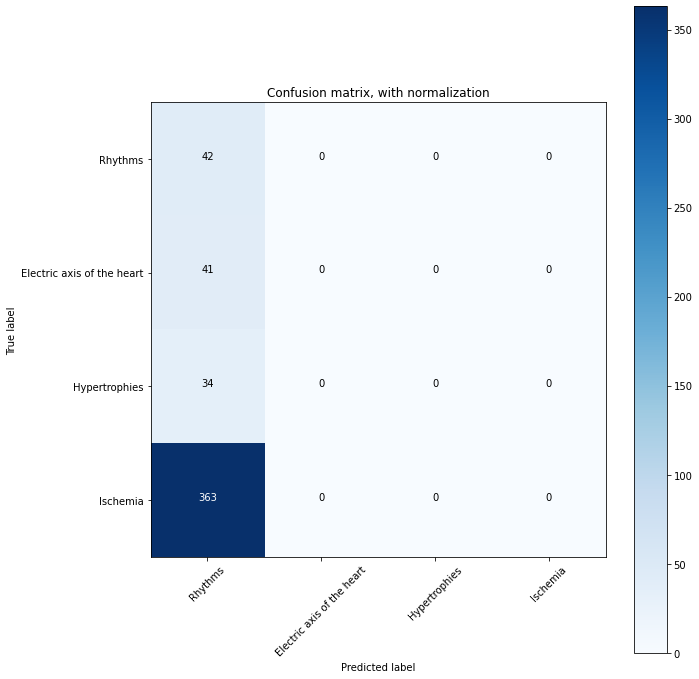

In [39]:
# Plot non-normalized confusion matrix


cnf_matrix = skm.confusion_matrix(y_test_.argmax(axis=1), y_pred_.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['Rhythms', 'Electric axis of the heart', 'Hypertrophies', 'Ischemia'],normalize=False,
                        title='Confusion matrix, with normalization')
plt.savefig("end_md4", dpi=300)
plt.show()